
# ENVIRONMENTAL SETUP



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
% cd "/content/"
! rm -r src/ 
! mkdir src
% cd src/
! cp "/content/drive/MyDrive/Colab Notebooks/Gait/DATASET.zip" .
! unzip DATASET.zip > unzip_log.txt
! rm DATASET.zip
! rm unzip_log.txt

/content
/content/src


In [3]:
! ls

DATASET


# IMPORTING LIBRARIES

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras import layers 
import tensorflow
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
import keras
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers.wrappers import TimeDistributed

# FEATURE EXTRACTION

In [5]:
features = []
labels = []
label_names = ["fast_walk", "in_coat", "normal", "slow_walk", "with_bag"]

In [6]:
folders = os.listdir("./DATASET")

for folder in folders:
    if folder not in label_names:
        continue
    images = os.listdir("./DATASET/" + folder + "/")
    # print(folder)
    # print(images)
    print("Reading images from " + folder)
    count = 0
    for img in tqdm(images):
        # For limiting number of images to 1000 per class
        # if count == MAX_LIMIT: break
        count += 1
        labels.append(folder)
        IMG_PATH = "./DATASET/" + folder + "/" + img
        img_data = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
        img_data = cv2.resize(img_data, (150, 150))
        features.append(img_data)

Reading images from fast_walk


100%|██████████| 301/301 [00:00<00:00, 1280.86it/s]


Reading images from in_coat


100%|██████████| 500/500 [00:00<00:00, 1369.72it/s]


Reading images from with_bag


100%|██████████| 500/500 [00:00<00:00, 1398.21it/s]


Reading images from normal


100%|██████████| 500/500 [00:00<00:00, 1374.73it/s]


Reading images from slow_walk


100%|██████████| 472/472 [00:00<00:00, 1415.46it/s]


In [7]:
len(features)

2273

In [8]:
len(labels)

2273

In [9]:
features[0].shape # 3 because of RGB value

(150, 150, 3)

In [10]:
features[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# VISUALISATION

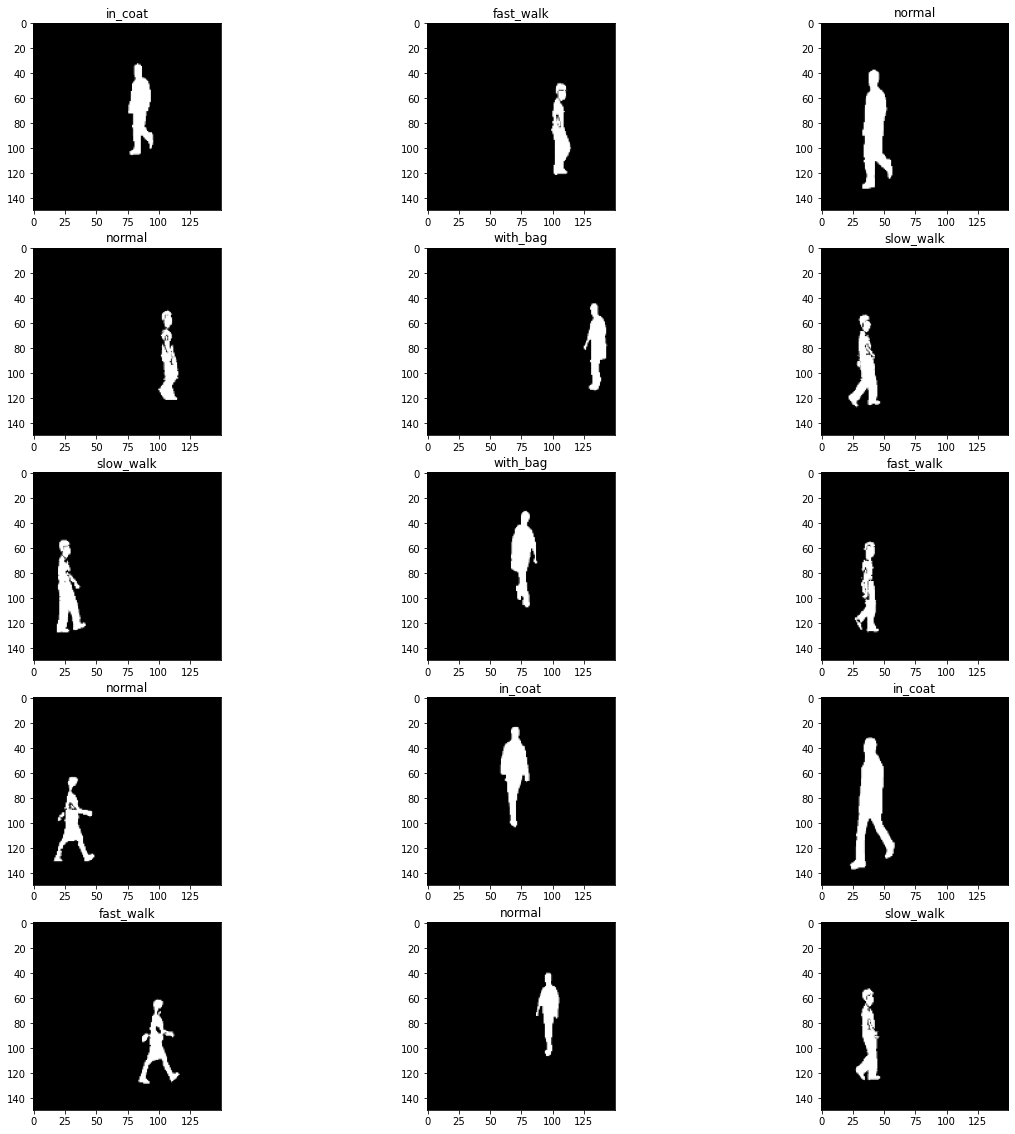

In [11]:
import random
fig,axis = plt.subplots(5,3)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range(3):
         ran = random.randrange(len(labels))
         axis[i,j].imshow(cv2.cvtColor(features[ran], cv2.COLOR_BGR2RGB)) #Converts from BGR to RGB
         axis[i,j].set_title(labels[ran])

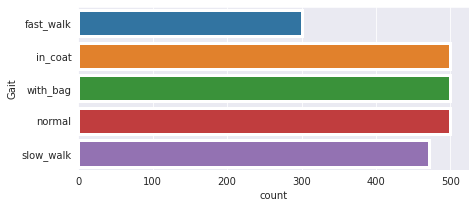

In [12]:
sns.set_style('darkgrid')
plt.figure(figsize=(7,3))
fig=sns.countplot(y=labels,linewidth=3)
plt.ylabel('Gait')
plt.show()

In [13]:
features=np.array(features)
features=features/255.0
features=features.reshape(-1,1,150,150,3)

In [14]:
features.shape

(2273, 1, 150, 150, 3)

In [15]:
le=LabelEncoder()
y=le.fit_transform(labels)

In [16]:
y=to_categorical(y)
y.shape

(2273, 5)

# TRAINING
**OPTIMISER ADAM**

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(features,y,random_state=11,test_size=0.2)

In [18]:
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

number of training examples = 1818
number of test examples = 455
x_train shape: (1818, 1, 150, 150, 3)
y_train shape: (1818, 5)
x_test shape: (455, 1, 150, 150, 3)
y_test shape: (455, 5)


In [19]:
class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# LAYERS -COMPARISON
6 LAYERS not working

In [20]:
callback = MyThresholdCallback(threshold=0.98)

In [21]:
import tensorflow as tf
tf.random.set_seed(10)

# 4 LAYERS

In [24]:
# adding CNN layers
model = Sequential()

#layer1
model.add(
    TimeDistributed(Conv2D(32, (5,5), activation = 'relu'), input_shape=(1,150,150,3))
    )
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer2
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer3
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer4
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))

'''
#layer5
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))
'''

model.add(TimeDistributed(Flatten()))

# adding LSTM
model.add(LSTM(128, return_sequences=False, dropout=0.4))


model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 1, 146, 146, 32)  2432      
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 1, 73, 73, 32)    0         
 stributed)                                                      
                                                                 
 dropout_10 (Dropout)        (None, 1, 73, 73, 32)     0         
                                                                 
 time_distributed_24 (TimeDi  (None, 1, 71, 71, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 1, 35, 35, 64)    0         
 stributed)                                           

**50 = 82.64**</br>
**75 = 80.22**</br>
**100 = 81.54**</br>
**150 = 79.56**</br>
**200 = 81.10**</br>
**250 = 74.73**</br>

In [25]:
history=model.fit(x_train,y_train,batch_size=12,epochs=100,validation_data=(x_test,y_test),callbacks=[callback])

Epoch 1/100
152/152 [==============================] - 11s 48ms/step - loss: 1.2458 - accuracy: 0.3916 - val_loss: 1.1809 - val_accuracy: 0.3956
Epoch 2/100
152/152 [==============================] - 6s 37ms/step - loss: 1.1280 - accuracy: 0.4268 - val_loss: 1.1566 - val_accuracy: 0.3912
Epoch 3/100
152/152 [==============================] - 5s 34ms/step - loss: 1.1218 - accuracy: 0.4384 - val_loss: 1.1284 - val_accuracy: 0.4352
Epoch 4/100
152/152 [==============================] - 5s 34ms/step - loss: 1.0822 - accuracy: 0.4725 - val_loss: 1.1251 - val_accuracy: 0.4330
Epoch 5/100
152/152 [==============================] - 5s 36ms/step - loss: 1.0400 - accuracy: 0.5110 - val_loss: 1.0734 - val_accuracy: 0.4857
Epoch 6/100
152/152 [==============================] - 5s 35ms/step - loss: 0.9972 - accuracy: 0.5363 - val_loss: 1.0374 - val_accuracy: 0.5099
Epoch 7/100
152/152 [==============================] - 5s 34ms/step - loss: 0.9330 - accuracy: 0.5688 - val_loss: 0.9995 - val_accuracy

In [26]:
y_pred_model = model.predict(x_test)
y_pred_model=np.argmax(y_pred_model, axis=1)
y_test_pred=np.argmax(y_test, axis=1)
cm_model = confusion_matrix(y_test_pred, y_pred_model)

print(cm_model)

[[58  0  1  8  1]
 [ 0 88  1  0  8]
 [ 5 15 53 15  8]
 [ 0  0  3 86  0]
 [ 0 10  4  2 89]]


In [27]:
print(classification_report(y_test_pred, y_pred_model))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89        68
           1       0.78      0.91      0.84        97
           2       0.85      0.55      0.67        96
           3       0.77      0.97      0.86        89
           4       0.84      0.85      0.84       105

    accuracy                           0.82       455
   macro avg       0.83      0.83      0.82       455
weighted avg       0.83      0.82      0.82       455



# 5 Layers
DROPOUTS = 6

In [28]:
# adding CNN layers
model = Sequential()

#layer1
model.add(
    TimeDistributed(Conv2D(32, (5,5), activation = 'relu'), input_shape=(1,150,150,3))
    )
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer2
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer3
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer4
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))


#layer5
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))


model.add(TimeDistributed(Flatten()))

# adding LSTM
model.add(LSTM(128, return_sequences=False, dropout=0.4))


model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_31 (TimeDi  (None, 1, 146, 146, 32)  2432      
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 1, 73, 73, 32)    0         
 stributed)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 1, 73, 73, 32)     0         
                                                                 
 time_distributed_33 (TimeDi  (None, 1, 71, 71, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 1, 35, 35, 64)    0         
 stributed)                                           

**50 = 83.52**</br>
**75 = 80.44**</br>
**100 = 84.18**</br>
**150 = 80.88**</br>
**200 = 81.98**</br>
**250 = 77.36**</br>

In [30]:
history=model.fit(x_train,y_train,batch_size=12,epochs=250,validation_data=(x_test,y_test),callbacks=[callback])

Epoch 1/250
152/152 [==============================] - 5s 34ms/step - loss: 0.5754 - accuracy: 0.7701 - val_loss: 0.6906 - val_accuracy: 0.7209
Epoch 2/250
152/152 [==============================] - 5s 32ms/step - loss: 0.5443 - accuracy: 0.7712 - val_loss: 0.6347 - val_accuracy: 0.7385
Epoch 3/250
152/152 [==============================] - 5s 33ms/step - loss: 0.5095 - accuracy: 0.7882 - val_loss: 0.6646 - val_accuracy: 0.7473
Epoch 4/250
152/152 [==============================] - 5s 33ms/step - loss: 0.4798 - accuracy: 0.8146 - val_loss: 0.6388 - val_accuracy: 0.7648
Epoch 5/250
152/152 [==============================] - 5s 33ms/step - loss: 0.4488 - accuracy: 0.8300 - val_loss: 0.5993 - val_accuracy: 0.7758
Epoch 6/250
152/152 [==============================] - 5s 33ms/step - loss: 0.4134 - accuracy: 0.8388 - val_loss: 0.6205 - val_accuracy: 0.7780
Epoch 7/250
152/152 [==============================] - 5s 33ms/step - loss: 0.3894 - accuracy: 0.8432 - val_loss: 0.6153 - val_accuracy:

In [31]:
y_pred_model = model.predict(x_test)
y_pred_model=np.argmax(y_pred_model, axis=1)
y_test_pred=np.argmax(y_test, axis=1)
cm_model = confusion_matrix(y_test_pred, y_pred_model)

print(cm_model)

[[ 57   0   6   5   0]
 [  0  89   6   0   2]
 [  3   9  60  16   8]
 [  1   0  10  78   0]
 [  0   3   2   0 100]]


In [32]:
print(classification_report(y_test_pred, y_pred_model))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        68
           1       0.88      0.92      0.90        97
           2       0.71      0.62      0.67        96
           3       0.79      0.88      0.83        89
           4       0.91      0.95      0.93       105

    accuracy                           0.84       455
   macro avg       0.85      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455



# DROPOUTS

**# DROPOUTS = 5**

In [23]:
callback = MyThresholdCallback(threshold=0.98)

In [24]:
import tensorflow as tf
tf.random.set_seed(10)

In [33]:
# adding CNN layers
model = Sequential()

#layer1 - DROPOUT1
model.add(
    TimeDistributed(Conv2D(32, (5,5), activation = 'relu'), input_shape=(1,150,150,3))
    )
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer2 - DROPOUT2
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer3  - DROPOUT3
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer4 - DROPOUT4
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))


#layer5
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))

# adding LSTM  - DROPOUT5
model.add(LSTM(128, return_sequences=False, dropout=0.4))


model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 1, 146, 146, 32)  2432      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 1, 73, 73, 32)    0         
 stributed)                                                      
                                                                 
 dropout_19 (Dropout)        (None, 1, 73, 73, 32)     0         
                                                                 
 time_distributed_44 (TimeDi  (None, 1, 71, 71, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 1, 35, 35, 64)    0         
 stributed)                                           

In [35]:
history=model.fit(x_train,y_train,batch_size=12,epochs=100,validation_data=(x_test,y_test),callbacks=[callback])

Epoch 1/100
152/152 [==============================] - 6s 39ms/step - loss: 1.3130 - accuracy: 0.3674 - val_loss: 1.1676 - val_accuracy: 0.4286
Epoch 2/100
152/152 [==============================] - 5s 31ms/step - loss: 1.1360 - accuracy: 0.4527 - val_loss: 1.0977 - val_accuracy: 0.4484
Epoch 3/100
152/152 [==============================] - 5s 32ms/step - loss: 1.1686 - accuracy: 0.4197 - val_loss: 1.1471 - val_accuracy: 0.4308
Epoch 4/100
152/152 [==============================] - 5s 35ms/step - loss: 1.1348 - accuracy: 0.4400 - val_loss: 1.1592 - val_accuracy: 0.4044
Epoch 5/100
152/152 [==============================] - 5s 36ms/step - loss: 1.1055 - accuracy: 0.4736 - val_loss: 1.1019 - val_accuracy: 0.4703
Epoch 6/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0791 - accuracy: 0.4879 - val_loss: 1.1052 - val_accuracy: 0.4527
Epoch 7/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0624 - accuracy: 0.4868 - val_loss: 1.0783 - val_accuracy:

**# DROPOUTS = 4**

In [36]:
# adding CNN layers
model = Sequential()

#layer1 - DROPOUT1
model.add(
    TimeDistributed(Conv2D(32, (5,5), activation = 'relu'), input_shape=(1,150,150,3))
    )
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer2 - DROPOUT2
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer3  - DROPOUT3
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer4
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))


#layer5
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))

# adding LSTM  - DROPOUT4
model.add(LSTM(128, return_sequences=False, dropout=0.4))


model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_53 (TimeDi  (None, 1, 146, 146, 32)  2432      
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 1, 73, 73, 32)    0         
 stributed)                                                      
                                                                 
 dropout_23 (Dropout)        (None, 1, 73, 73, 32)     0         
                                                                 
 time_distributed_55 (TimeDi  (None, 1, 71, 71, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 1, 35, 35, 64)    0         
 stributed)                                           

In [37]:
history=model.fit(x_train,y_train,batch_size=12,epochs=100,validation_data=(x_test,y_test),callbacks=[callback])

Epoch 1/100
152/152 [==============================] - 29s 173ms/step - loss: 1.3278 - accuracy: 0.3570 - val_loss: 1.2071 - val_accuracy: 0.4198
Epoch 2/100
152/152 [==============================] - 5s 32ms/step - loss: 1.1560 - accuracy: 0.4334 - val_loss: 1.1692 - val_accuracy: 0.3824
Epoch 3/100
152/152 [==============================] - 5s 32ms/step - loss: 1.1157 - accuracy: 0.4571 - val_loss: 1.1242 - val_accuracy: 0.4462
Epoch 4/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0907 - accuracy: 0.4648 - val_loss: 1.1082 - val_accuracy: 0.4374
Epoch 5/100
152/152 [==============================] - 5s 33ms/step - loss: 1.0422 - accuracy: 0.4928 - val_loss: 1.0197 - val_accuracy: 0.4989
Epoch 6/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0178 - accuracy: 0.5132 - val_loss: 1.0214 - val_accuracy: 0.5077
Epoch 7/100
152/152 [==============================] - 5s 33ms/step - loss: 0.9524 - accuracy: 0.5490 - val_loss: 0.9760 - val_accurac

**# DROPOUTS = 7**

In [38]:
# adding CNN layers
model = Sequential()

#layer1 - DROPOUT1
model.add(
    TimeDistributed(Conv2D(32, (5,5), activation = 'relu'), input_shape=(1,150,150,3))
    )
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer2 - DROPOUT2
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer3 - DROPOUT3
model.add(
    TimeDistributed(Conv2D(64, (3, 3), activation='relu'))
    ) 
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.1))

#layer4 - DROPOUT4
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))


#layer5 - DROPOUT5
model.add(
    TimeDistributed(Conv2D(128, (3, 3), activation='relu'))
    )
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.1))

#DROPOUT6
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.1))

# adding LSTM  - DROPOUT7
model.add(LSTM(128, return_sequences=False, dropout=0.4))


model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 1, 146, 146, 32)  2432      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 1, 73, 73, 32)    0         
 stributed)                                                      
                                                                 
 dropout_26 (Dropout)        (None, 1, 73, 73, 32)     0         
                                                                 
 time_distributed_66 (TimeDi  (None, 1, 71, 71, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 1, 35, 35, 64)    0         
 stributed)                                           

In [39]:
history=model.fit(x_train,y_train,batch_size=12,epochs=100,validation_data=(x_test,y_test),callbacks=[callback])

Epoch 1/100
152/152 [==============================] - 9s 38ms/step - loss: 1.3429 - accuracy: 0.3504 - val_loss: 1.1778 - val_accuracy: 0.4242
Epoch 2/100
152/152 [==============================] - 5s 32ms/step - loss: 1.1556 - accuracy: 0.4417 - val_loss: 1.1156 - val_accuracy: 0.4220
Epoch 3/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0920 - accuracy: 0.4681 - val_loss: 1.0622 - val_accuracy: 0.4813
Epoch 4/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0766 - accuracy: 0.4791 - val_loss: 1.0816 - val_accuracy: 0.4352
Epoch 5/100
152/152 [==============================] - 5s 31ms/step - loss: 1.0479 - accuracy: 0.4824 - val_loss: 1.0563 - val_accuracy: 0.4681
Epoch 6/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0432 - accuracy: 0.4890 - val_loss: 1.0214 - val_accuracy: 0.4857
Epoch 7/100
152/152 [==============================] - 5s 32ms/step - loss: 1.0185 - accuracy: 0.5028 - val_loss: 1.0179 - val_accuracy:

# GRAPHS

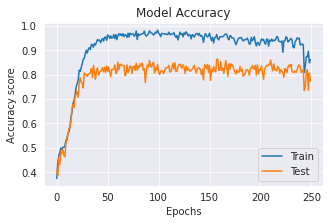

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.title('Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

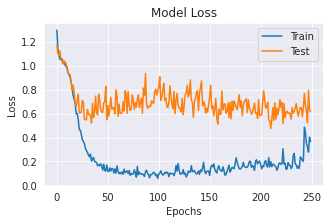

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train','Test'])
plt.show()

# PREDICTION

In [ ]:
predict=model.predict(x_test)
predict=np.argmax(predict,axis=1)

In [ ]:
incorrect_preds=[] 

for i in range(len(y_test)):
    if(np.argmax(y_test[i])!=predict[i]):
        incorrect_preds.append(i)
    if len(incorrect_preds)==10:
        break

In [ ]:
print(len(incorrect_preds))

10


In [ ]:
path = "/content/src/DATASET/with_bag/001-bg-01-000-018.png"
img_array_test = cv2.imread(os.path.join(path),cv2.IMREAD_COLOR) #to read the image
img_array_test = cv2.resize(img_array_test,(150,150)) #resize the image uniformly into 220x220 array
features_test = img_array_test

features_test=np.array(features_test)
features_test=features_test/255.0
features_test=features_test.reshape(-1,1,150,150,3)

In [ ]:
features_test.shape

(1, 1, 150, 150, 3)

In [ ]:
predict_test=model.predict(features_test)
predict_test=np.argmax(predict_test)
predict_test=predict_test+1

In [ ]:
predict_test

2

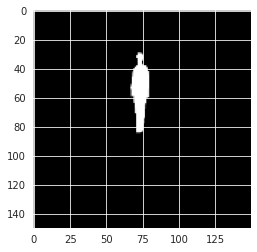

In [ ]:
plt.imshow(cv2.cvtColor(img_array_test, cv2.COLOR_BGR2RGB))
plt.show()